In [ ]:
%%HTML
<style> code {background-color : pink !important;} </style>

In [ ]:
# from matplotlib import interactive
# interactive(True)
# and

# interactive(False)

In [3]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
#         img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
#         cv2.imshow('img',img)
#         cv2.waitKey(500)

cv2.destroyAllWindows()

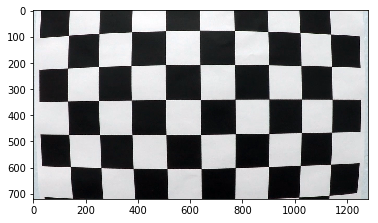

In [4]:
import os
os.chdir('/media/pemfir/Data/UdacityProjects/Code/P4-AdvanceLane/camera_cal')
img = cv2.imread('calibration1.jpg')
plt.imshow(img)

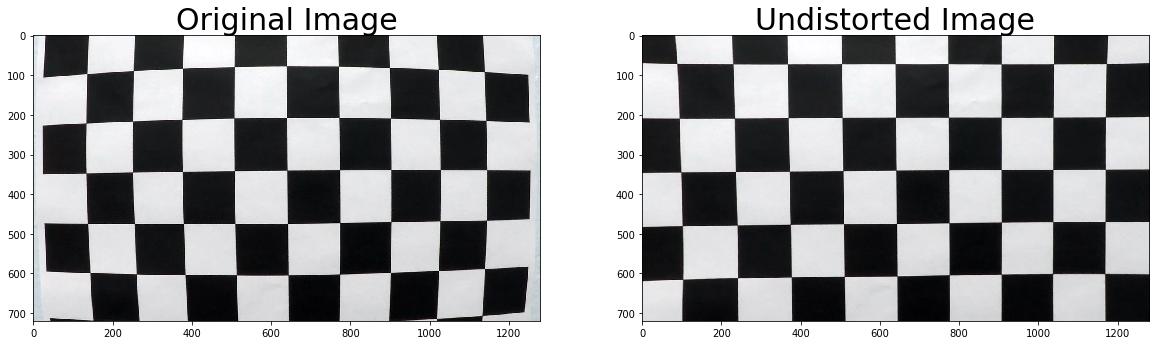

In [5]:
import pickle
%matplotlib inline

# Test undistortion on an image
img = cv2.imread('calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


dst = cv2.undistort(img, mtx, dist, None, mtx)
cv2.imwrite('test_undist.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)

Camera Calibration with OpenCV
===

### Run the code in the cell below to extract object points and image points for camera calibration.  

### If the above cell ran sucessfully, you should now have `objpoints` and `imgpoints` needed for camera calibration.  Run the cell below to calibrate, calculate distortion coefficients, and test undistortion on an image!

perpective transform is changing front image as though you are looking from the top at an image. 

distortion correction fixes issues with the impact of lense on warping the corner of an image.

camera caliberation is about finding the camera matrix so that you can correct for distortion 


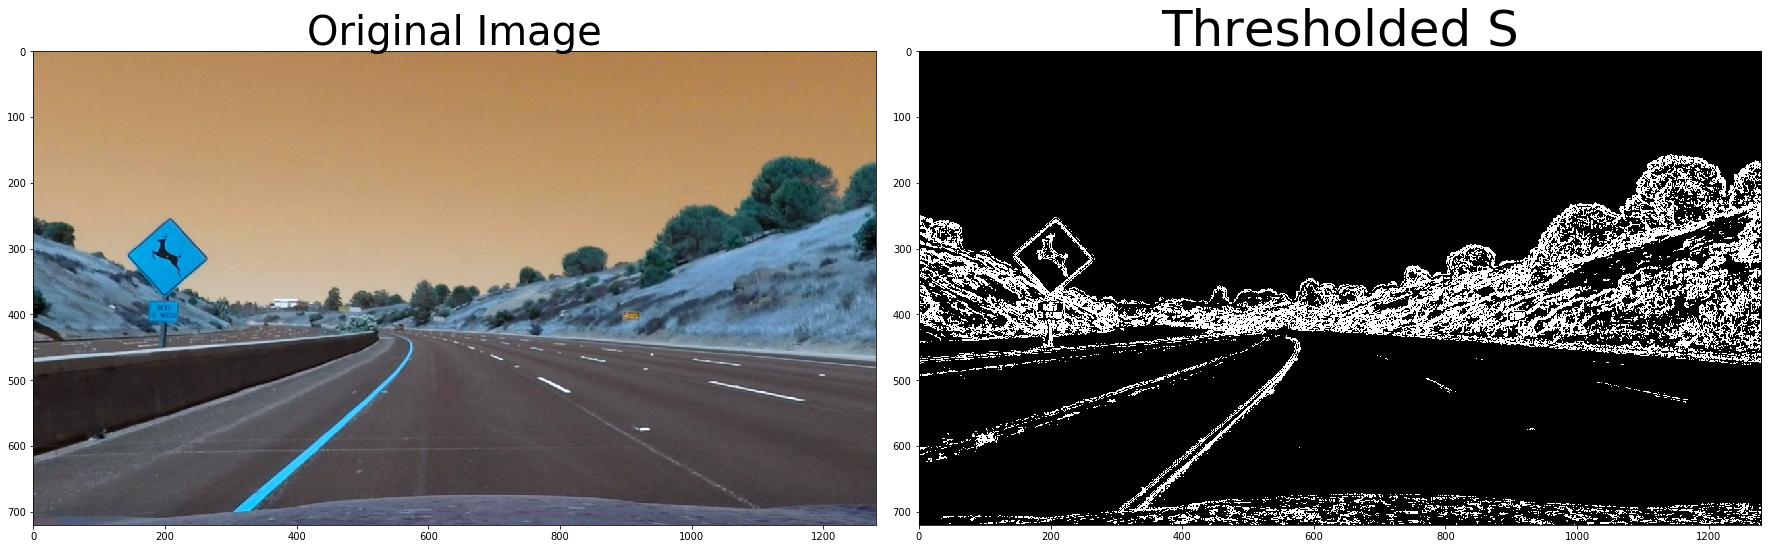

In [6]:

loc = '/media/pemfir/Data/UdacityProjects/Code/P4-AdvanceLane/test_images'
os.chdir(loc)
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = cv2.imread('test2.jpg')
img = img
img = cv2.undistort(img, mtx, dist, None, mtx)



def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)    
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel =  np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>mag_thresh[0]) & (scaled_sobel <mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
#     binary_output = np.copy(img) # Remove this line
#     return binary_output
    return binary_output

# image = mpimg.imread('signs_vehicles_xygrad.jpg')

# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(20, 255), sx_thresh=(2, 100), h_thresh=(0, 280)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hsv[:,:,0]
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]

    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    magbinary = mag_thresh(img, sobel_kernel=3, mag_thresh=(10, 100))
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
#     be beneficial to replace this channel with something else.
    combined = np.zeros_like(h_channel)
    combined[(s_binary == 1) & (magbinary  == 1) & (sxbinary  == 1) ] = 1
    
#     color_binary = np.dstack(( h_binary, sxbinary, s_binary))
    color_binary = combined
    return color_binary
    
binary_warped = pipeline(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

In [7]:
img_size

(1280, 720)

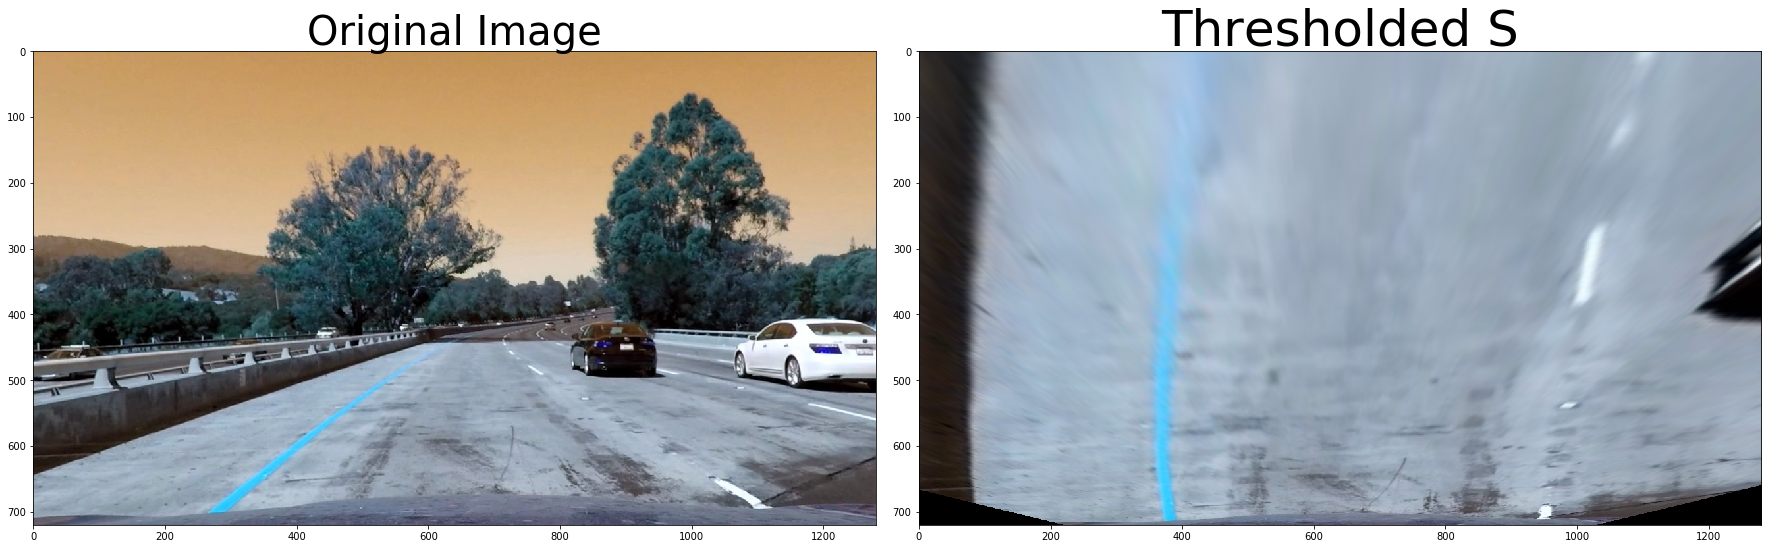

In [41]:
%matplotlib inline

loc = '/media/pemfir/Data/UdacityProjects/Code/P4-AdvanceLane/test_images'
os.chdir(loc)
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = cv2.imread('test1.jpg')
# undistort image 
img = cv2.undistort(img, mtx, dist, None, mtx)
offset = 350
# in the cv2 transformation first dimension is x second is y 
# in image.shape first dimension is y then x
img_size = (img.shape[1],img.shape[0])
src = np.float32([[585,460],
                  [203,720],
                  [1127,720],
                  [695,460]])
dst = np.float32([[offset,0],
                  [offset,img_size[1]],
                  [img_size[0]-offset,img_size[1]],
                  [img_size[0]-offset,0]])
# dst = np.float32([[320,0],
#                   [320,720],
#                   [960,720],
#                   [960,0]])
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)
warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
# plt.imshow()
# plt.show()


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(warped)
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

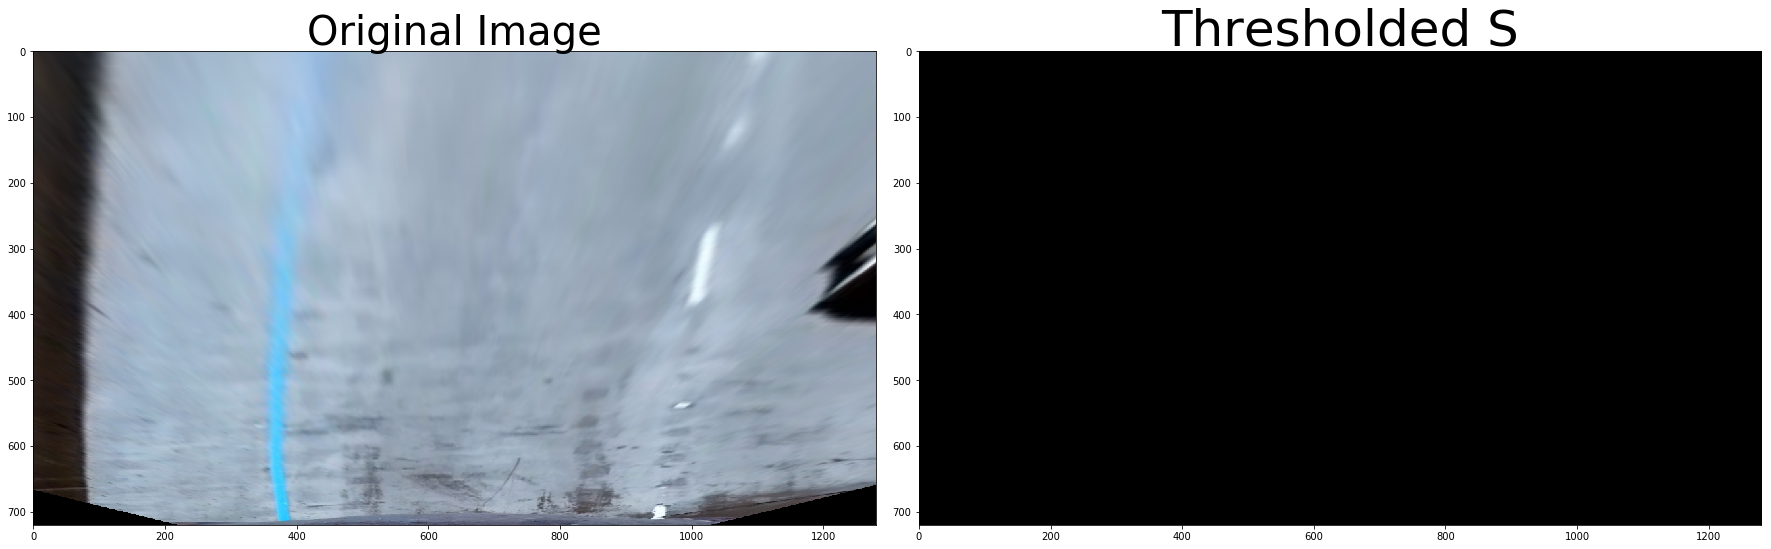

In [58]:

# image = mpimg.imread('signs_vehicles_xygrad.jpg')
img = warped
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize=sobel_kernel) 
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1,ksize=sobel_kernel)    
    # 3) Calculate the magnitude 
    mag = np.sqrt(sobelx**2 + sobely**2)
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel =  np.uint8(255*mag/np.max(mag))
    # 5) Create a binary mask where mag thresholds are met
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel>mag_thresh[0]) & (scaled_sobel <mag_thresh[1])] = 1
    # 6) Return this mask as your binary_output image
#     binary_output = np.copy(img) # Remove this line
#     return binary_output
    return binary_output


# Edit this function to create your own pipeline.
def pipeline(img, s_thresh=(1, 255), sx_thresh=(0, 1000), h_thresh=(0, 280)):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hlv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    h_channel = hlv[:,:,0]
    l_channel = hlv[:,:,1]
    s_channel = hlv[:,:,2]
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
#     h_channel = hsv[:,:,0]
#     s_channel = hsv[:,:,1]
    v_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    magbinary = mag_thresh(img, sobel_kernel=3, mag_thresh=(10, 100))
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    h_binary = np.zeros_like(h_channel)
    h_binary[(h_channel >= h_thresh[0]) & (h_channel <= h_thresh[1])] = 1
    v_binary = np.zeros_like(h_channel)
    v_binary[(v_channel >= 0) & (v_channel <= 255)] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
#     be beneficial to replace this channel with something else.
    combined = np.zeros_like(h_channel)
    combined[(s_binary == 1) & (v_binary == 1) & (magbinary  == 1) & (sxbinary  == 1) ] = 1
    
#     color_binary = np.dstack(( h_binary, sxbinary, s_binary))
    color_binary = combined
    return color_binary
    
binary_warped = pipeline(img)

# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(img)
ax1.set_title('Original Image', fontsize=40)

ax2.imshow(binary_warped, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

plt.show()

In [59]:
sxbinary

NameError: name 'sxbinary' is not defined

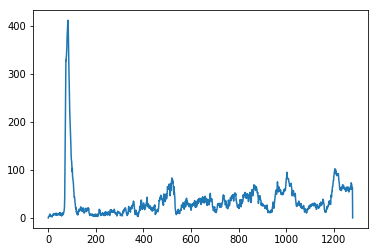

In [32]:
import numpy as np
histogram = np.sum(binary_warped, axis=0)
plt.plot(histogram)


(720, 0)

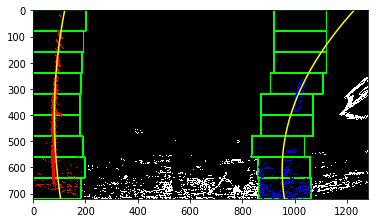

In [33]:


import numpy as np
import cv2
import matplotlib.pyplot as plt

# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
# Create an output image to draw on and  visualize the result
# there will be two pixel values 0 and 255 
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
# looking at the two peaks form the histogram 
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
# y coordinates of non-zero pixels
nonzeroy = np.array(nonzero[0])
# x coordinates of non-zero pixels
nonzerox = np.array(nonzero[1])
# Current positions of ?(line?) to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows of ?! +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# go through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    # we are defining a rectangular area 
    # from the center of the lane to left and right of it  
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5)
    # Identify the nonzero pixels in x and y within the window
    # retuns the indexes of points inside each rectangle 
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    # otherwise the last center point we have is used 
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
# notice that we are fitting f(y) = x 
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# creating y points across the image from 0 to height of image pixel by pixel to 
# feed into the polynomial function to 
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
# we feed the y's and the polynomial gives us the corresponding x's
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
# color coding the point clouds that are used to draw the line in the output image
# the points that are on the left get [255,0,0] and all non zero points on right [0,0,255]
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img.astype('uint8'))
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


(720, 0)

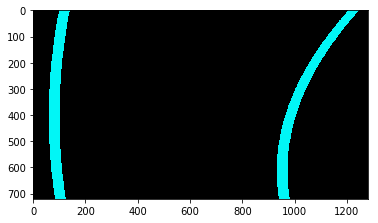

In [34]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
margin = 20
# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
# left_fitx points from the polygon 
# points are [x - margin , y] , and [x + margin, y] across y (ploty) and x values comes from the polynomial
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (255,10, 10))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (255,10, 10))
# result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(window_img)
result = window_img
# plt.imshow(result)
# plt.plot(left_fitx, ploty, color='yellow')
# plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


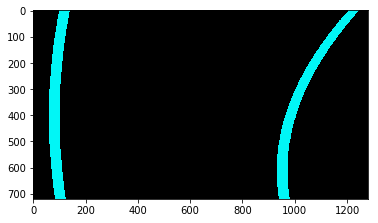

In [35]:
plt.imshow(result)

In [36]:
leftx.shape

(10343,)

In [37]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

2153.32848663 704.638699161
684.146010747 m 222.954119879 m


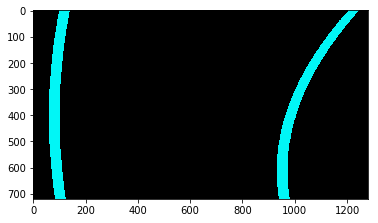

In [38]:
plt.imshow(result)

In [40]:
img_size = (result.shape[1], result.shape[0])
unwarped = cv2.warpPerspective(result, Minv, img_size, flags=cv2.INTER_LINEAR)
img = cv2.imread('test1.jpg').astype('float')
outputImage = cv2.addWeighted(img,1.0,unwarped,1.0,0.0)
cv2.imwrite('./Result3.jpg',outputImage.astype('float'))


True

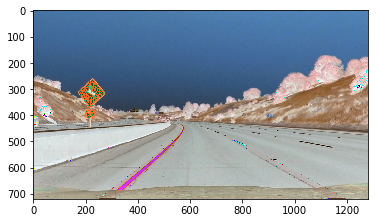

In [26]:
plt.imshow(outputImage)

In [27]:
result = np.zeros_like(outputImage)
R = outputImage[:,:,0]
B = outputImage[:,:,1]
G = outputImage[:,:,2]
result[:,:,0]= R
result[:,:,1]= B
result[:,:,2]= G


In [ ]:
plt.imsave('result',result)

In [ ]:
cv2.imshow('img',img)
